<a href="https://colab.research.google.com/github/obeabi/Assignments/blob/master/Main_DecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Tree Assignment 
## Written by Abiola Obembe
### Date: 2021-02-02
### Course: ML masters with deployment and deep learning
### Objective: Predicting Survival in the Titanic Data Set
-----------------------------------------------------------------------------
### ----------  Assignment starts here -------------------------------------------------

## Dataset
We will be using a decision tree to make predictions about the Titanic data
set from Kaggle. This data set provides information on the Titanic
passengers and can be used to predict whether a passenger survived or
not. You use only Pclass, Sex, Age, SibSp (Siblings aboard), Parch
(Parents/children aboard), and Fare to predict whether a passenger
survived.

In [6]:
# Loading Data and modules
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn
from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn import metrics
!pip install fsspec

# Import other libraries
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category= FutureWarning)
warnings.filterwarnings("ignore", category = DeprecationWarning)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

print('Libraries installed successfully!')

np.random.seed(0)



     |████████████████████████████████| 102kB 3.9MB/s 
Libraries installed successfully!


In [9]:
# Load dataset
url= "https://raw.githubusercontent.com/BigDataGal/Python-for-Data-Science/master/titanic-train.csv"

titanic = pd.read_csv(url)
titanic.columns =['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']

titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
# Drop columns nor required as advised from question prompt
titanic.drop(['PassengerId', 'Name','Ticket','Cabin','Embarked'], axis = 1, inplace= True)

titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500


## Explorartory Data Analysis

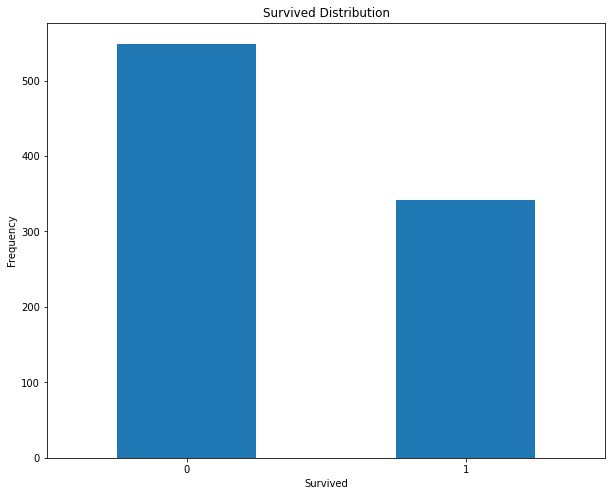

In [11]:
# Let's visualize the distribution of target data ( establishing imbalanced dataset)
count_classes = pd.value_counts(titanic['Survived'], sort = True)
count_classes.plot(kind = 'bar', rot = 0)
plt.title("Survived Distribution")
plt.xticks(range(2))
plt.xlabel("Survived")
plt.ylabel('Frequency')
plt.show()

In [12]:
# Bascic statistics
titanic.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [13]:
# Check for missing values
print("The missing values in each column are as below :")
titanic.isna().sum()

The missing values in each column are as below :


Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
dtype: int64

In [16]:
# Check if Age is missing at random
titanic.groupby(titanic['Age'].isnull()).mean()

,Survived,Pclass,Age,SibSp,Parch,Fare
Age,,,,,,
False,0.406162,2.236695,29.699118,0.512605,0.431373,34.694514
True,0.293785,2.598870,NaN,0.564972,0.180791,22.158567


We observe that 40% of the missing ages survived as compared to 20% for passengers with age not missing. This implies that Age was not missing at random. We will create an indicator variable to capture this.

In [18]:
# Create indicator variablle
titanic['age_ind']= np.where(titanic['Age'].isnull(), 0,1)

titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,age_ind
0,0,3,male,22.0,1,0,7.2500,1
1,1,1,female,38.0,1,0,71.2833,1
2,1,3,female,26.0,0,0,7.9250,1
3,1,1,female,35.0,1,0,53.1000,1
4,0,3,male,35.0,0,0,8.0500,1
